In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import statistics as st
from datetime import datetime
import os

In [44]:
model_path = "/home/aevans/convLSTM/src/data/temp_df/20240615/Mohawk Valley/20240615_20:21_ml_output.parquet"

clim_div = 'Mohawk Valley'

full_df_path = '/home/aevans/nwp_bias/src/machine_learning/data/images/master_df.csv'

In [45]:
nysm_cats_path = "/home/aevans/nwp_bias/src/landtype/data/nysm.csv"
nysm_cats_df = pd.read_csv(nysm_cats_path)
stations = nysm_cats_df[nysm_cats_df['climate_division_name']==clim_div]['stid'].unique()
stations

array(['CAMD', 'HERK', 'JOHN', 'OPPE', 'SPRA', 'WEST'], dtype=object)

In [46]:
df = pd.read_parquet(model_path)
df = df.sort_index()

In [47]:
full_df = pd.read_csv(full_df_path)

In [48]:
image_times = full_df['images'].tolist()

In [49]:
valid_times = []

In [50]:
# Define the format
date_format = "%Y%m%d_%H:%M"

for i in image_times:
    date_string = i[-18:-4]
    # Convert to datetime object
    date_time_obj = datetime.strptime(date_string, date_format)
    vt = date_time_obj.strftime("%Y-%m-%d %H:%M:%S")
    valid_times.append(vt)

In [51]:
df = df.iloc[:-1]

In [52]:
df['valid_time'] = valid_times

In [53]:
# model_path_lstm = "/home/aevans/nwp_bias/src/machine_learning/data/lstm_eval_csvs/20240608/CAMD/CAMD_loss_0.21557494811713696_ml_output_CAMD.parquet"

# df_lstm = pd.read_parquet(model_path_lstm)
# df_lstm = df_lstm.sort_index()

In [54]:
full_df_lstm = pd.read_parquet(
"/home/aevans/nwp_bias/src/machine_learning/data/lstm_eval_csvs/20240608/CAMD/06_08_2024_14:41:52_full_CAMD.parquet"
)

In [55]:
# df_lstm["valid_time"] = full_df_lstm["valid_time"]

In [56]:
df['valid_time'] = pd.to_datetime(df['valid_time'])

In [57]:
# new = df_lstm.merge(df, on='valid_time')

In [58]:
def which_fold(df, fold):
    length = len(df)
    test_len = int(length * 0.2)
    df_train = pd.DataFrame()

    for n in np.arange(0, 5):
        if n != fold:
            df1 = df.iloc[int(0.2 * n * length) : int(0.2 * (n + 1) * length)]
            df_train = pd.concat([df_train, df1])
        else:
            df_test = df.iloc[int(0.2 * n * length) : int(0.2 * (n + 1) * length)]

    return df_train['valid_time'], df_test['valid_time']

In [59]:
df_train, df_test = which_fold(full_df, 3)

In [60]:
df_test.iloc[0]

'2021-07-17 19:00:00'

In [61]:
df_test.iloc[-1]

'2022-09-18 14:00:00'

In [62]:
# vt = full_df['valid_time'].to_list()
# vt = vt[:int(len(df)-len(full_df))]
# df['valid_time'] = vt

In [63]:
# df = df[df['valid_time'] > datetime(2021, 9, 1, 0, 0, 0)]
# df = df[df['valid_time'] < datetime(2021, 9, 30, 23, 0, 0)]
#df = df.drop(columns='valid_time')

In [64]:
# df = df.iloc[int(len(df.iloc[:,0])*0.8):]

In [65]:
# for k in new.keys():
#     print(k)

In [66]:
# new = new.drop(columns= ['temperature_target_error_HERK',
# 'temperature_target_error_JOHN',
# 'temperature_target_error_OPPE',
# 'temperature_target_error_SPRA',
# 'temperature_target_error_WEST',])

In [67]:
df = df.iloc[-int(len(df.iloc[:,0])*0.02):]

In [68]:
def plot_outputs(df_out, clim_div, stations):
    import matplotlib.pyplot as plt 
    df_out = df_out.sort_index()
    fig, axs = plt.subplots(int(df_out.shape[1]/2), figsize=(21, 21), sharex=True, sharey=True)
    n = int(df_out.shape[1]/2)
    i = 0
    while n>i:
        axs[i].set_ylabel(f'{stations[i]}')
        axs[i].plot(df_out.iloc[:,i], c="r", label="Target")
        axs[i].plot(df_out.iloc[:,(i+6)], c="b", alpha=0.7, label="convLSTM Output")
        
        # print(f"Mean Absolute Difference of {stations[i]}: {abs(df_out.iloc[:,i] - df_out.iloc[:,(i+6)]).mean()}")
        i+=1
    fig.suptitle(f"convLSTM Output v Target", fontsize=28)
    axs[0].legend()
    plt.tight_layout()

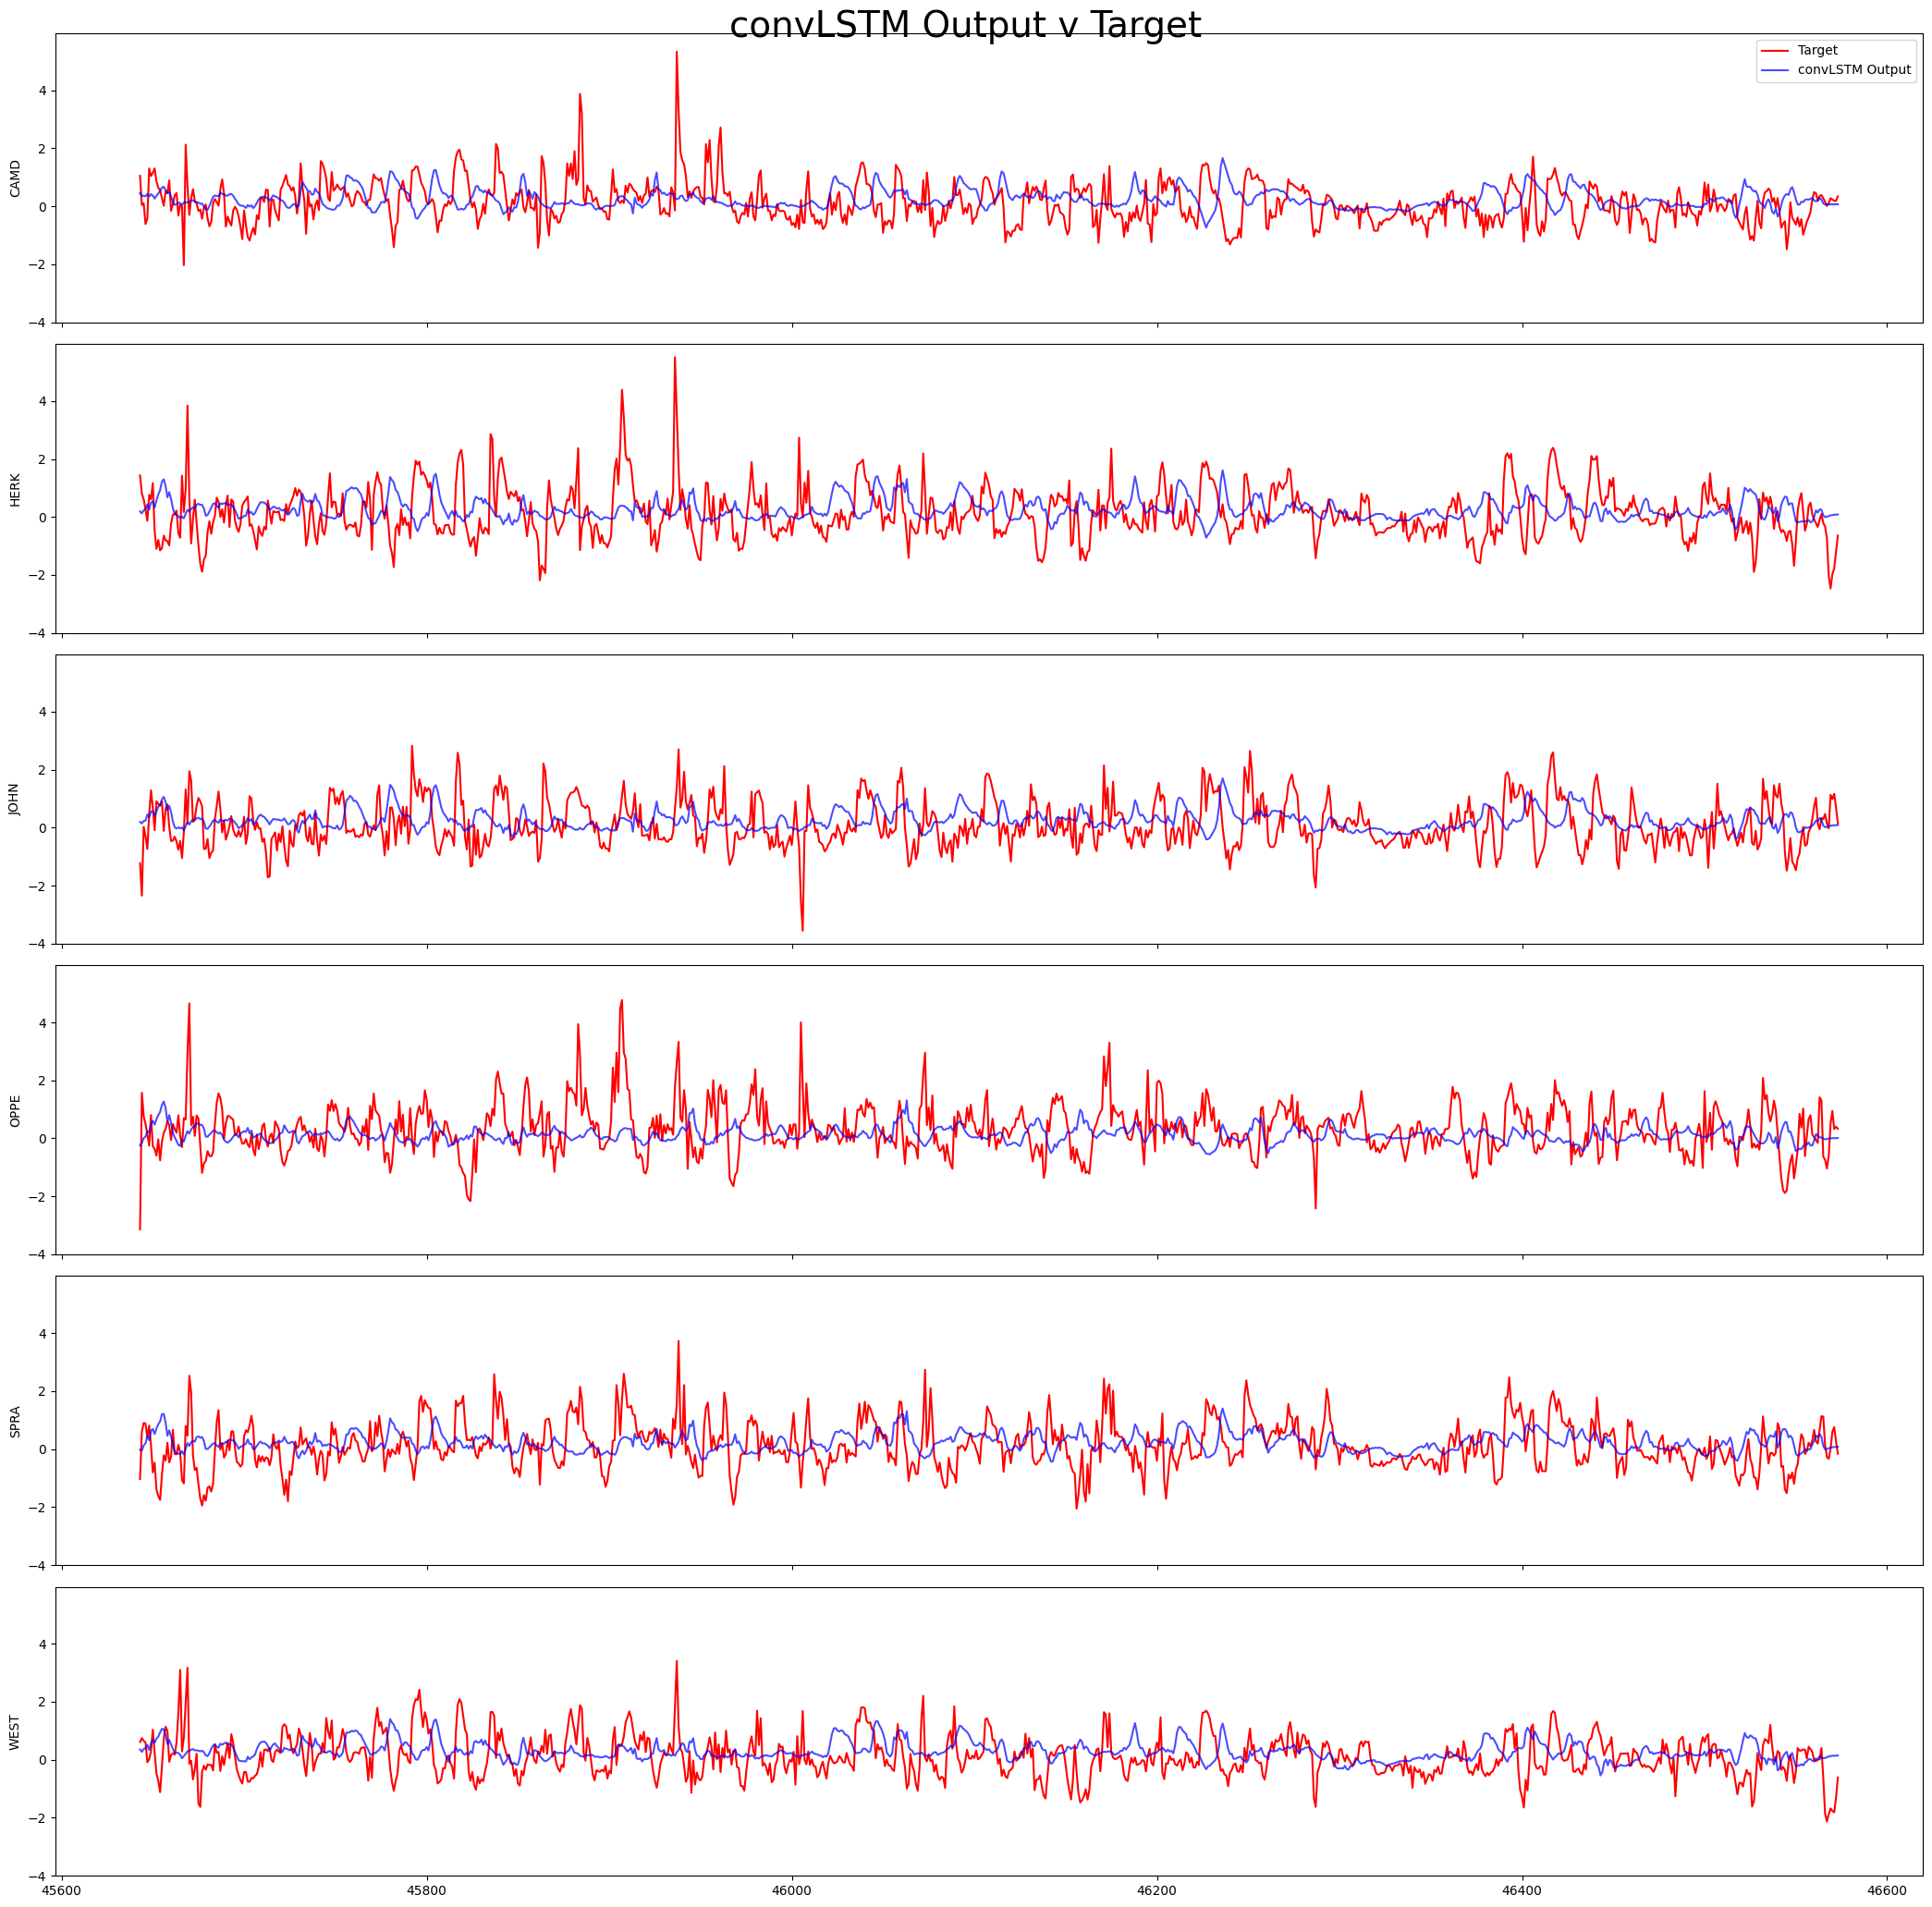

In [69]:
plot_outputs(df, clim_div, stations)

In [ ]:
# new = new.iloc[-int(len(new['valid_time'])*0.02):]

In [ ]:
new

In [ ]:
new = new.iloc[42700:43000]

In [ ]:
import matplotlib.pyplot as plt 
fig, axs = plt.subplots(figsize=(21, 9), sharex=True, sharey=True)
i = 0
plt.plot(new['valid_time'], new['target_error_lead_0'], c='blue', label = 'Target')
plt.plot(new['valid_time'], new['Model forecast'], c='red', label = 'LSTM', alpha=0.7)
fig.suptitle(f"convLSTM Output v Target", fontsize=28)
plt.legend()
plt.tight_layout()
print(st.mean(abs(new['target_error_lead_0'] - new['Model forecast'])))

In [ ]:
import matplotlib.pyplot as plt 
fig, axs = plt.subplots(figsize=(21, 9), sharex=True, sharey=True)
i = 0
plt.plot(new['valid_time'], new['temperature_target_error_CAMD'], c='blue', label = 'Target')
plt.plot(new['valid_time'], new['Model forecast'], c='red', label = 'LSTM', alpha=0.7)
plt.plot(new['valid_time'], new['temperature_target_error_CAMD_prediction'], c='green', label='convLSTM', alpha = 0.7)
fig.suptitle(f"convLSTM Output v Target", fontsize=28)
plt.legend()
plt.tight_layout()
print(st.mean(abs(new['temperature_target_error_CAMD'] - new['temperature_target_error_CAMD_prediction'])))

In [ ]:
def plot_layers_2d(img_name):
    # Load the image
    image = np.load(img_name).astype(np.float32)
    
    # Get the number of layers
    num_layers = image.shape[2]

    # Set up the figure and axes
    fig, ax = plt.subplots(figsize=(5, 5))
    
    # Iterate over each layer
    for i in range(num_layers):
        # Get the layer data
        layer_data = image[:, :, i]

        # Create a new figure for each layer
        plt.figure(figsize=(5, 5))
        
        # Plot the layer
        plt.imshow(layer_data, cmap='viridis')
        plt.colorbar()
        
        # Set the title
        # plt.title(f'Layer {i + 1}')
        plt.axis('off')  # Hide the axis

        # Show the plot
        plt.tight_layout()
        plt.show()